In [2]:
X_scr_pin = []
Y_scr_pin = []

X_scr_ban = []
Y_scr_ban = []

X_pin_ban = []
Y_pin_ban = []

with open('./scorpions_pinginus.csv', newline='') as csfile:
    spamreader = csv.reader(csfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        X_scr_pin.append(row[0])
        Y_scr_pin.append(int(row[1]))

with open('./scorpions_bananka.csv', newline='') as csfile:
    spamreader = csv.reader(csfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        X_scr_ban.append(row[0])
        Y_scr_ban.append(int(row[1]))

with open('./pinginus_bananka.csv', newline='') as csfile:
    spamreader = csv.reader(csfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        X_pin_ban.append(row[0])
        Y_pin_ban.append(int(row[1]))

In [58]:
X_train_scr_pin, X_test_scr_pin, Y_train_scr_pin, Y_test_scr_pin = train_test_split(X_scr_pin, Y_scr_pin, test_size=0.2)

X_train_scr_ban, X_test_scr_ban, Y_train_scr_ban, Y_test_scr_ban = train_test_split(X_scr_ban, Y_scr_ban, test_size=0.2)

X_train_pin_ban, X_test_pin_ban, Y_train_pin_ban, Y_test_pin_ban = train_test_split(X_pin_ban, Y_pin_ban, test_size=0.2)

In [59]:
def compute_data(X, n=8):

    kaze = cv2.KAZE_create()
    m = len(X)
    X_res = np.zeros((m,n))
    i = 0
    for x in X:
        img = cv2.imread(x, 0)
        img = cv2.resize(img, (128, 128))
        kp, des = kaze.detectAndCompute(img, None)

        pt = [i.pt for i in kp]
        pt_arr = np.array(pt)
        if pt_arr.shape[0] < n:
            if len(pt) != 0:
                for j in range(pt_arr.shape[0]):
                    X_res[i,j] = 1 / pt_arr.shape[0]
        else:
            kmeans = KMeans(n_clusters=n, random_state=0).fit(pt_arr)
            list_masks = [ kmeans.labels_ == i for i in range(n)]

            j = 0
            for mask in list_masks:
                pt_mask = np.round(pt_arr[mask,:], 0).astype(np.int)
                hist = np.sum(img[pt_mask[:,0], pt_mask[:,1]]) / np.sum(mask)
                X_res[i,j] = hist
                j += 1
        i += 1

    return X_res

In [60]:
train_scr_pin = compute_data(X_train_scr_pin)
train_scr_ban = compute_data(X_train_scr_ban)
train_pin_ban = compute_data(X_train_pin_ban)

y_train_scr_pin = np.zeros((train_scr_pin.shape[0], 2))
y_train_scr_ban = np.zeros((train_scr_ban.shape[0], 2))
y_train_pin_ban = np.zeros((train_pin_ban.shape[0], 2))

for i in range(train_scr_pin.shape[0]):
    y_train_scr_pin[i, Y_train_scr_pin[i]] = 1

for i in range(train_scr_ban.shape[0]):
    y_train_scr_ban[i, Y_train_scr_ban[i]] = 1

for i in range(train_pin_ban.shape[0]):
    y_train_pin_ban[i, Y_train_pin_ban[i]] = 1

test_scr_pin = compute_data(X_test_scr_pin)
test_scr_ban = compute_data(X_test_scr_ban)
test_pin_ban = compute_data(X_test_pin_ban)

y_test_scr_pin = np.array(Y_test_scr_pin)
y_test_scr_ban = np.array(Y_test_scr_ban)
y_test_pin_ban = np.array(Y_test_pin_ban)

In [77]:
def model(n=8):
    key_points = keras.layers.Input(shape=(1,n), dtype='float32')
    X = keras.layers.BatchNormalization()(key_points)
    X = keras.layers.LSTM(512, return_sequences=True)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.LSTM(512, return_sequences=True)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.LSTM(512, return_sequences=False)(X)
    X = keras.layers.Dropout(rate=0.5)(X)
    X = keras.layers.Dense(units=2)(X)
    X = keras.layers.Activation(activation='softmax')(X)

    model = keras.Model(inputs=key_points, outputs=X)

    return model

In [78]:
example = model(n=8)
example.summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 1, 8)]            0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1, 8)              32        
_________________________________________________________________
lstm_45 (LSTM)               (None, 1, 512)            1067008   
_________________________________________________________________
dropout_45 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 1, 512)            2099200   
_________________________________________________________________
dropout_46 (Dropout)         (None, 1, 512)            0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 512)             

In [79]:
model_scr_pin = model()
model_scr_ban = model()
model_pin_ban = model()

In [82]:
model_scr_pin.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_scr_ban.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pin_ban.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [83]:
X_train_scr_pin_arr = train_scr_pin[:, np.newaxis, :]
X_train_scr_ban_arr = train_scr_ban[:, np.newaxis, :]
X_train_pin_ban_arr = train_pin_ban[:, np.newaxis, :]


X_test_scr_pin_arr = test_scr_pin[:,np.newaxis, :]
X_test_scr_ban_arr = test_scr_ban[:,np.newaxis, :]
X_test_pin_ban_arr = test_pin_ban[:,np.newaxis, :]

In [87]:
model_scr_pin.fit(X_train_scr_pin_arr, y_train_scr_pin, epochs=52, batch_size=32, shuffle=True)

Epoch 1/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6274 - accuracy: 0.6372
Epoch 2/52
22/22 [==============================] - 1s 28ms/step - loss: 0.6193 - accuracy: 0.6342
Epoch 3/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6427 - accuracy: 0.6091
Epoch 4/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6258 - accuracy: 0.6460
Epoch 5/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6310 - accuracy: 0.6416
Epoch 6/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6291 - accuracy: 0.6401
Epoch 7/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6259 - accuracy: 0.6313
Epoch 8/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6197 - accuracy: 0.6357
Epoch 9/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6284 - accuracy: 0.6342
Epoch 10/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6152 - accuracy: 0.6460
Epoch 11/

In [85]:
model_scr_ban.fit(X_train_scr_ban_arr, y_train_scr_ban, epochs=52, batch_size=32, shuffle=True)

Epoch 1/52
21/21 [==============================] - 1s 28ms/step - loss: 0.6931 - accuracy: 0.4886
Epoch 2/52
21/21 [==============================] - 1s 29ms/step - loss: 0.6901 - accuracy: 0.5023
Epoch 3/52
21/21 [==============================] - 1s 28ms/step - loss: 0.6855 - accuracy: 0.4871
Epoch 4/52
21/21 [==============================] - 1s 28ms/step - loss: 0.6776 - accuracy: 0.5539
Epoch 5/52
21/21 [==============================] - 1s 28ms/step - loss: 0.6694 - accuracy: 0.5751
Epoch 6/52
21/21 [==============================] - 1s 27ms/step - loss: 0.6541 - accuracy: 0.5918
Epoch 7/52
21/21 [==============================] - 1s 30ms/step - loss: 0.6553 - accuracy: 0.5827
Epoch 8/52
21/21 [==============================] - 1s 29ms/step - loss: 0.6570 - accuracy: 0.5797
Epoch 9/52
21/21 [==============================] - 1s 28ms/step - loss: 0.6543 - accuracy: 0.6055
Epoch 10/52
21/21 [==============================] - 1s 29ms/step - loss: 0.6416 - accuracy: 0.6267
Epoch 11/

In [86]:
model_pin_ban.fit(X_train_pin_ban_arr, y_train_pin_ban, epochs=52, batch_size=32, shuffle=True)

Epoch 1/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6929 - accuracy: 0.5103
Epoch 2/52
22/22 [==============================] - 1s 28ms/step - loss: 0.6871 - accuracy: 0.5472
Epoch 3/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6741 - accuracy: 0.5590
Epoch 4/52
22/22 [==============================] - 1s 28ms/step - loss: 0.6660 - accuracy: 0.5900
Epoch 5/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6426 - accuracy: 0.6622
Epoch 6/52
22/22 [==============================] - 1s 28ms/step - loss: 0.6356 - accuracy: 0.6519
Epoch 7/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6351 - accuracy: 0.6652
Epoch 8/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6422 - accuracy: 0.6416
Epoch 9/52
22/22 [==============================] - 1s 28ms/step - loss: 0.6278 - accuracy: 0.6534
Epoch 10/52
22/22 [==============================] - 1s 27ms/step - loss: 0.6106 - accuracy: 0.6785
Epoch 11/

In [88]:
y_pred_scr_pin = model_scr_pin.predict(X_test_scr_pin_arr)
y_pred_scr_pin_target = np.argmax(y_pred_scr_pin, axis=1)

y_pred_scr_ban = model_scr_ban.predict(X_test_scr_ban_arr)
y_pred_scr_ban_target = np.argmax(y_pred_scr_ban, axis=1)

y_pred_pin_ban = model_pin_ban.predict(X_test_pin_ban_arr)
y_pred_pin_ban_target = np.argmax(y_pred_pin_ban, axis=1)

In [89]:
accuracy_scr_pin = recall_score(y_test_scr_pin, y_pred_scr_pin_target)
accuracy_scr_ban = recall_score(y_test_scr_ban, y_pred_scr_ban_target)
accuracy_pin_ban = recall_score(y_test_pin_ban, y_pred_pin_ban_target)

recall_scr_pin = recall_score(y_test_scr_pin, y_pred_scr_pin_target)
recall_scr_ban = recall_score(y_test_scr_ban, y_pred_scr_ban_target)
recall_pin_ban = recall_score(y_test_pin_ban, y_pred_pin_ban_target)

precision_scr_pin = precision_score(y_test_scr_pin, y_pred_scr_pin_target)
precision_scr_ban = precision_score(y_test_scr_ban, y_pred_scr_ban_target)
precision_pin_ban = precision_score(y_test_pin_ban, y_pred_pin_ban_target)

f1_scr_pin = f1_score(y_test_scr_pin, y_pred_scr_pin_target)
f1_scr_ban = f1_score(y_test_scr_ban, y_pred_scr_ban_target)
f1_pin_ban = f1_score(y_test_pin_ban, y_pred_pin_ban_target)

confusion_matrix_scr_pin = pd.DataFrame(confusion_matrix(y_test_scr_pin, y_pred_scr_pin_target))
confusion_matrix_scr_ban = pd.DataFrame(confusion_matrix(y_test_scr_ban, y_pred_scr_ban_target))
confusion_matrix_pin_ban = pd.DataFrame(confusion_matrix(y_test_pin_ban, y_pred_pin_ban_target))

Scorpions Pinginus
accuracy: 0.625
recall: 0.625
precission: 0.5617977528089888
f1: 0.591715976331361


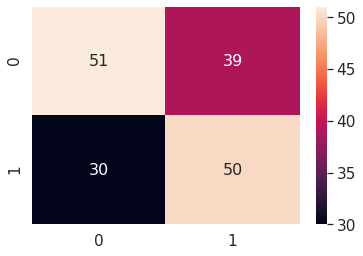

In [90]:
print('Scorpions Pinginus')
print(f'accuracy: {accuracy_scr_pin}')
print(f'recall: {recall_scr_pin}')
print(f'precission: {precision_scr_pin}')
print(f'f1: {f1_scr_pin}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_scr_pin, annot=True, annot_kws={'size': 16})


Scorpions Bananka
accuracy: 0.5769230769230769
recall: 0.5769230769230769
precission: 0.6521739130434783
f1: 0.6122448979591837


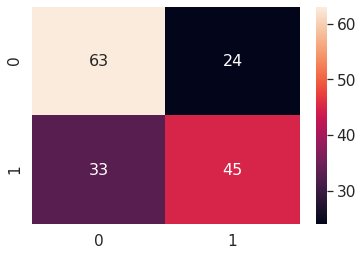

In [72]:
print('Scorpions Bananka')
print(f'accuracy: {accuracy_scr_ban}')
print(f'recall: {recall_scr_ban}')
print(f'precission: {precision_scr_ban}')
print(f'f1: {f1_scr_ban}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_scr_ban, annot=True, annot_kws={'size': 16})

Pinginus Bananka
accuracy: 0.5934065934065934
recall: 0.5934065934065934
precission: 0.7297297297297297
f1: 0.6545454545454545


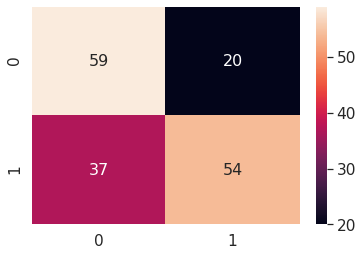

In [73]:
print('Pinginus Bananka')
print(f'accuracy: {accuracy_pin_ban}')
print(f'recall: {recall_pin_ban}')
print(f'precission: {precision_pin_ban}')
print(f'f1: {f1_pin_ban}')

sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_pin_ban, annot=True, annot_kws={'size': 16})

In [74]:
def compute_hist(frame, n=8):
    kaze = cv2.KAZE_create()
    m = 1
    X_res = np.zeros((m,n))

    img = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (128, 128))
    kp, des = kaze.detectAndCompute(img, None)

    pt = [i.pt for i in kp]
    pt_arr = np.array(pt)

    if pt_arr.shape[0] < n:
        if len(pt) != 0:
            for j in range(pt_arr.shape[0]):
                X_res[0,j] = 1 / pt_arr.shape[0]
    else:
        kmeans = KMeans(n_clusters=n, random_state=0).fit(pt_arr)
        list_masks = [ kmeans.labels_ == i for i in range(n)]

        j = 0
        for mask in list_masks:
            pt_mask = np.round(pt_arr[mask,:], 0).astype(np.int)
            hist = np.sum(img[pt_mask[:,0], pt_mask[:,1]]) / np.sum(mask)
            X_res[0,j] = hist
            j += 1

    return X_res

In [91]:
cap = cv2.VideoCapture('test.mp4')

if (cap.isOpened() == False):
    print("Unable to read camera feed")

frame_width = int(cap.get(4))
frame_height = int(cap.get(3))

out = cv2.VideoWriter('scor_pin.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret, frame = cap.read()

    if ret == True:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        X = compute_hist(frame)[np.newaxis, :, :]
        class_object = np.argmax(model_scr_pin.predict(X))
        position = (25, 350)
        cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 2, (209, 80, 0, 255), 3)
        out.write(frame)

    else:
        break

cap.release()
out.release()

cv2.destroyAllWindows()

In [92]:
cap = cv2.VideoCapture('test.mp4')

if (cap.isOpened() == False):
    print("Unable to read camera feed")

frame_width = int(cap.get(4))
frame_height = int(cap.get(3))

out = cv2.VideoWriter('scor_ban.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

while(True):
    ret, frame = cap.read()

    if ret == True:
        frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
        X = compute_hist(frame)[np.newaxis, :, :]
        class_object = np.argmax(model_scr_ban.predict(X))
        position = (25, 350)
        cv2.putText(frame, 'Class ' + str(class_object), position, cv2.FONT_HERSHEY_SIMPLEX, 2, (209, 80, 0, 255), 3)
        out.write(frame)

    else:
        break

cap.release()
out.release()

cv2.destroyAllWindows()